# Задача проекта  
Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

# Описание этапа обработки  
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.  
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).  
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.  
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).  

# Описание данных  
Данные состоят из файлов, полученных из разных источников:  
* data_arc.csv - данные об электродах;  
* data_bulk.csv — данные о подаче сыпучих материалов (объём);  
* data_bulk_time.csv — данные о подаче сыпучих материалов (время);  
* data_gas.csv — данные о продувке сплава газом;  
* data_temp.csv — результаты измерения температуры;  
* data_wire.csv — данные о проволочных материалах (объём);  
* data_wire_time.csv — данные о проволочных материалах (время).  

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## План работы над проектом:  
1. Проведем исследовательский анализ данных.  
2. Проведем предобработку данных.  
3. Определим признаки которые нам будут необходимы для дальнейшей работы над проектом.  
4. Соеденим нужные нам данные в одну таблицу.  
5. Определим модели, кторые будем использовать (я пока думаю на XGBoos, LightGBM, LinearRegression).  
6. Сравним полученные результаты и выберем лучшую модель.  
7. Напишем отсчет.  

## 1. Исследовательский анализ данных

In [2]:
# импортируем нужные библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [3]:
try:    
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
except:
    data_arc = pd.read_csv('data_arc.csv')
    data_bulk = pd.read_csv('data_bulk.csv')
    data_bulk_time = pd.read_csv('data_bulk_time.csv')
    data_gas = pd.read_csv('data_gas.csv')
    data_temp = pd.read_csv('data_temp.csv')
    data_wire = pd.read_csv('data_wire.csv')
    data_wire_time = pd.read_csv('data_wire_time.csv')

In [4]:
# загрузим данные
#data_arc = pd.read_csv("data_arc.csv")
data_arc.head(5)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [5]:
#data_bulk = pd.read_csv("data_bulk.csv")
data_bulk.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [6]:
#data_bulk_time = pd.read_csv("data_bulk_time.csv")
data_bulk_time.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [7]:
#data_gas = pd.read_csv("data_gas.csv")
data_gas.head(5)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [8]:
#data_temp = pd.read_csv("data_temp.csv")
data_temp.head(5)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [9]:
#data_wire = pd.read_csv("data_wire.csv")
data_wire.head(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#data_wire_time = pd.read_csv("data_wire_time.csv")
data_wire_time.head(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### data_arc - данные об электродах

In [11]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [12]:
data_arc.duplicated().sum()

0

In [13]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Из данных видно что пропусков в данных нет, дбликатов так же нет. Столбцы **Начало нагрева дугой и Конец нагрева дугой** имеют неправильный формат, необходимо заменить на datetime, в столбе **Реактивная мощность** есть значение -715 скорее всего это аномалия

In [14]:
#изменим тип данных
data_arc["Начало нагрева дугой"] = pd.to_datetime(data_arc["Начало нагрева дугой"])
data_arc["Конец нагрева дугой"] = pd.to_datetime(data_arc["Конец нагрева дугой"])
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [15]:
# посчитаем количество партий
data_arc["key"].nunique()

3214

<AxesSubplot:xlabel='key', ylabel='Density'>

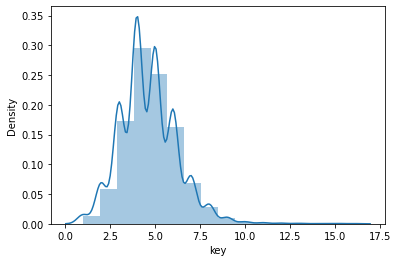

In [16]:
#построим график
sns.distplot(data_arc["key"].value_counts(), bins=16)

Количество итераций для каждой партии отличается от 1 до 16

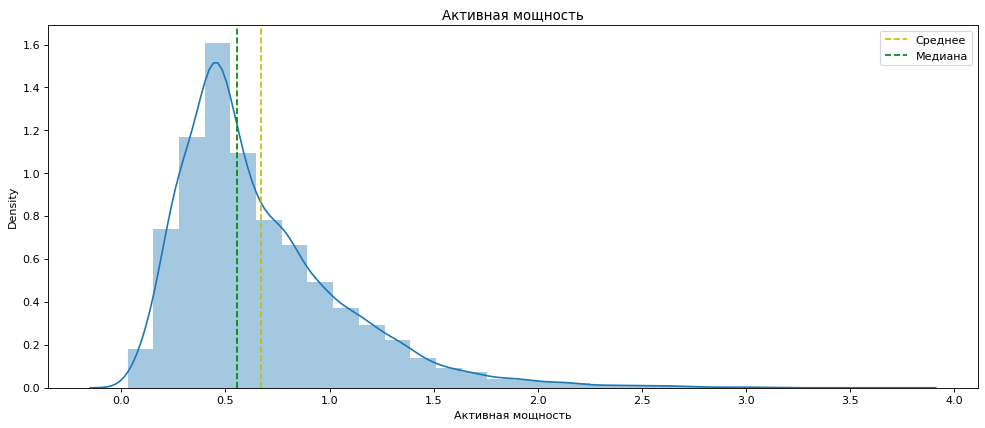

In [17]:
#построим график распределения активной мощности
plt.figure(figsize=(15, 6), dpi= 80)
sns.distplot(data_arc["Активная мощность"], bins=30)
plt.axvline(data_arc["Активная мощность"].mean(), ls='--', color='y', label='Среднее')
plt.axvline(data_arc["Активная мощность"].median(), ls='--', color='g', label='Медиана')
plt.title("Активная мощность")
plt.legend()
plt.show()

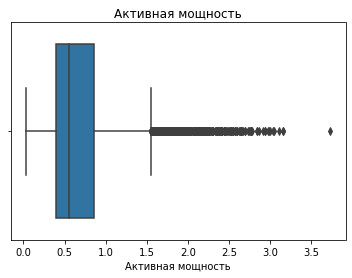

In [18]:
sns.boxplot(data_arc["Активная мощность"])
plt.title("Активная мощность")
plt.show()

Распределение нормальное со сдвигом влево

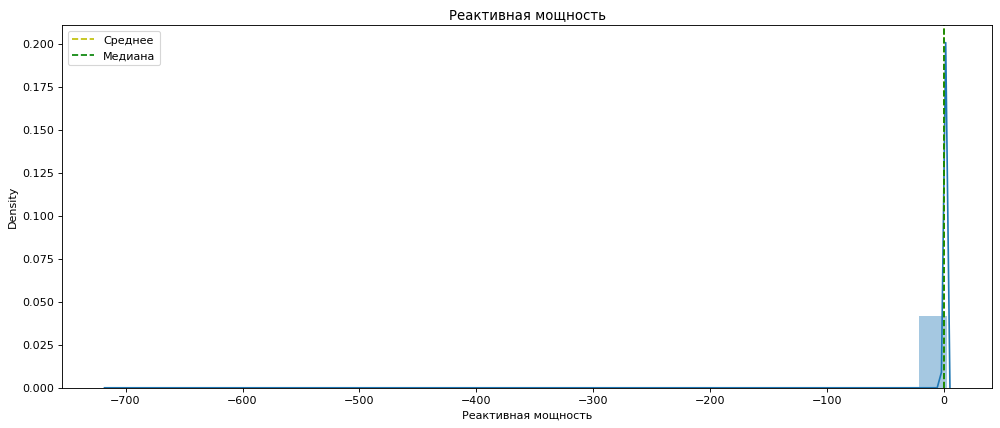

In [19]:
#построим график распределения реактивной мощности
plt.figure(figsize=(15, 6), dpi= 80)
sns.distplot(data_arc["Реактивная мощность"], bins=30)
plt.axvline(data_arc["Реактивная мощность"].mean(), ls='--', color='y', label='Среднее')
plt.axvline(data_arc["Реактивная мощность"].median(), ls='--', color='g', label='Медиана')
plt.title("Реактивная мощность")
plt.legend()
plt.show()

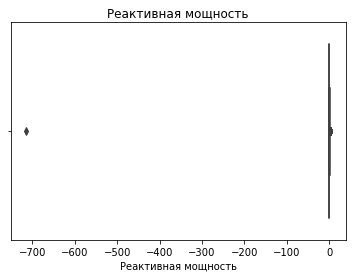

In [20]:
sns.boxplot(data_arc["Реактивная мощность"])
plt.title("Реактивная мощность")
plt.show()

На лицо наличие выбросов, избавимся от них

In [21]:
data_arc = data_arc[data_arc["Реактивная мощность"] >= 0]

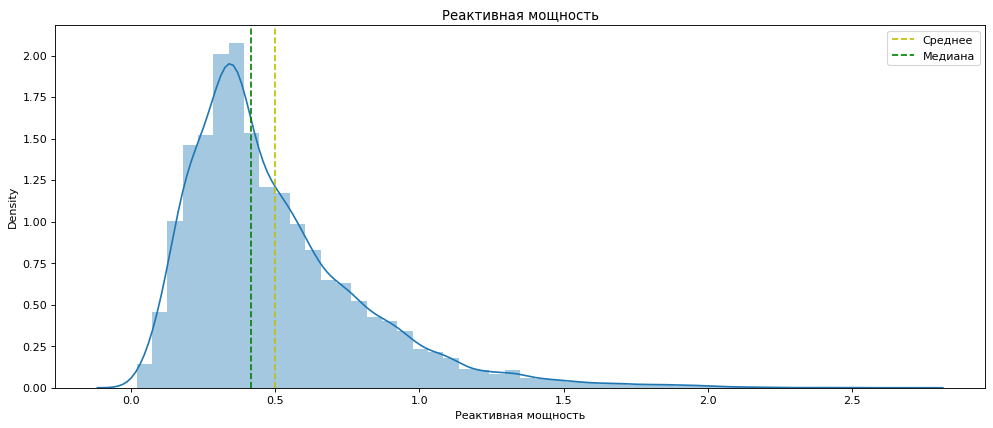

In [22]:
plt.figure(figsize=(15, 6), dpi= 80)
sns.distplot(data_arc["Реактивная мощность"], bins=50)
plt.axvline(data_arc["Реактивная мощность"].mean(), ls='--', color='y', label='Среднее')
plt.axvline(data_arc["Реактивная мощность"].median(), ls='--', color='g', label='Медиана')
plt.title("Реактивная мощность")
plt.legend()
plt.show()

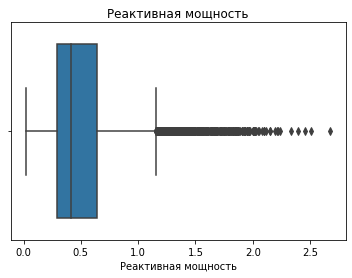

In [23]:
sns.boxplot(data_arc["Реактивная мощность"])
plt.title("Реактивная мощность")
plt.show()

Распределение нормальное со сдвигом влево

In [24]:
#проверим корреляцию между активной и реактивной мощьностями
print("Корреляция между активной и реактивной мощностями", data_arc["Активная мощность"].corr(data_arc["Реактивная мощность"]))

Корреляция между активной и реактивной мощностями 0.963181913151981


Мы видим что активная и реактивная мощности сильно коррелируют между собой и это может привести к переобучению нашей модели. Разберемся что такое активная и реактивная мощности

Исходя из информации взятой с сайта:  https://ru.wikipedia.org/wiki/%D0%AD%D0%BB%D0%B5%D0%BA%D1%82%D1%80%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D0%BC%D0%BE%D1%89%D0%BD%D0%BE%D1%81%D1%82%D1%8C#%D0%90%D0%BA%D1%82%D0%B8%D0%B2%D0%BD%D0%B0%D1%8F_%D0%BC%D0%BE%D1%89%D0%BD%D0%BE%D1%81%D1%82%D1%8C  
Мы видим что:  
**1. Активная мощность** единица измерения в СИ — ватт
$$
P=U\cdot I\cdot \cos \varphi 
$$
Среднее за период {\displaystyle T}T значение мгновенной мощности называется активной электрической мощностью или электрической мощностью:  
$$
{\displaystyle P={\frac {1}{T}}\int \limits _{0}^{T}p(t)dt}.
$$
**2. Реактивная мощность**  
$$
Q=U\cdot I\cdot \sin \varphi .
$$
Реактивная мощность — величина, характеризующая нагрузки, создаваемые в электротехнических устройствах колебаниями энергии электромагнитного поля в цепи синусоидального переменного тока, равна произведению среднеквадратичных значений напряжения **U** и тока **I**, умноженному на синус угла сдвига фаз между ними. Реактивная мощность связана с полной мощностью **S** и активной мощностью **P** соотношением:
$$
{\displaystyle |Q|={\sqrt {S^{2}-P^{2}}}.}
$$
**3. Полная мощность**  
Полная мощность — величина, равная произведению действующих значений периодического электрического тока **I** в цепи и напряжения **U** на её зажимах связана с активной и реактивной мощностями соотношением:
$$
{\displaystyle S={\sqrt {P^{2}+Q^{2}}},}
$$
где - P - активная мощность  
Q - реактивная мощность  
Полная мощность имеет практическое значение, как величина, описывающая нагрузки, фактически налагаемые потребителем на элементы подводящей электросети (провода, кабели, распределительные щиты, трансформаторы, линии электропередачи), так как эти нагрузки зависят от потребляемого тока, а не от фактически использованной потребителем энергии. Именно поэтому полная мощность трансформаторов и распределительных щитов измеряется в вольт-амперах, а не в ваттах.

In [25]:
#напишем функцию для расчета полной мощности
def full_power(row):
    full_power = np.sqrt(row["Активная мощность"]**2 + row["Реактивная мощность"]**2)
    return full_power

In [26]:
data_arc["Полная мощность"] = data_arc.apply(full_power, axis=1)

In [27]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239


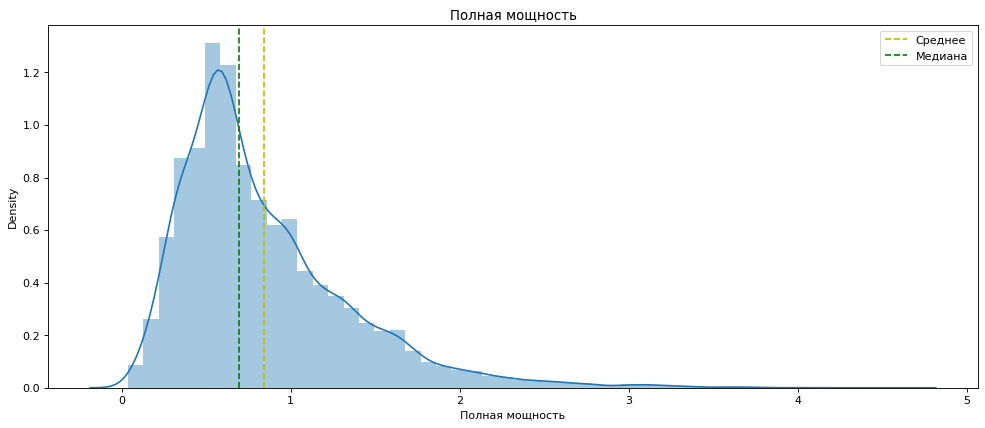

In [28]:
plt.figure(figsize=(15, 6), dpi= 80)
sns.distplot(data_arc["Полная мощность"], bins=50)
plt.axvline(data_arc["Полная мощность"].mean(), ls='--', color='y', label='Среднее')
plt.axvline(data_arc["Полная мощность"].median(), ls='--', color='g', label='Медиана')
plt.title("Полная мощность")
plt.legend()
plt.show()

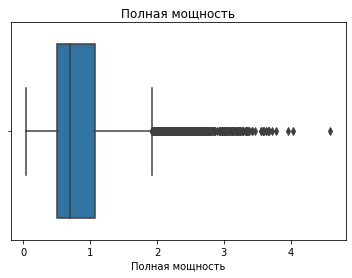

In [29]:
sns.boxplot(data_arc["Полная мощность"])
plt.title("Полная мощность")
plt.show()

Мы так же наблюдаем нормальное распределение со сдвигом влево

### Вывод:  
Мы изучили наш ДФ, пропущенных значений и дубликатов в нем нет, но есть аномалии (отрицательная реактивная мощность от которого мы избавились по ходу анализа) и не правильный формат данных в столбцах, который мы заменили на datetime. При проведении анализа мы увидели что данные имеют нормальное распределение и активная с реактивной мощностью имею большую корреляцию 0.96, и мы добавили новый признак полная мощность из теории (википедии)

### data_bulk — данные о подаче сыпучих материалов (объём)

In [30]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [31]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [32]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [33]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [34]:
data_bulk.duplicated().sum()

0

In [35]:
data_bulk["key"].nunique()

3129

### Вывод:  
Типы данных в этом датасете указанны верно, дубликатов нет, количество партий равно 3129.  
В данных есть большое количество пропущенных значений, это обусловлено тем что в каждую партию добавляют разное количество сыпучих материалов

### data_bulk_time — данные о подаче сыпучих материалов (время)

In [36]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [37]:
data_bulk_time.describe()

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


In [38]:
# посмотрим на наш ДФ
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [39]:
data_bulk_time["key"].nunique()

3129

В нашем ДФ столбцы имеют не правильный формат, и есть много пропусков в данных. Содержит 3129 партий

In [40]:
#заменим тип данных
data_bulk_time["Bulk 1"] = pd.to_datetime(data_bulk_time["Bulk 1"])
data_bulk_time["Bulk 2"] = pd.to_datetime(data_bulk_time["Bulk 2"])
data_bulk_time["Bulk 3"] = pd.to_datetime(data_bulk_time["Bulk 3"])
data_bulk_time["Bulk 4"] = pd.to_datetime(data_bulk_time["Bulk 4"])
data_bulk_time["Bulk 5"] = pd.to_datetime(data_bulk_time["Bulk 5"])
data_bulk_time["Bulk 6"] = pd.to_datetime(data_bulk_time["Bulk 6"])
data_bulk_time["Bulk 7"] = pd.to_datetime(data_bulk_time["Bulk 7"])
data_bulk_time["Bulk 8"] = pd.to_datetime(data_bulk_time["Bulk 8"])
data_bulk_time["Bulk 9"] = pd.to_datetime(data_bulk_time["Bulk 9"])
data_bulk_time["Bulk 10"] = pd.to_datetime(data_bulk_time["Bulk 10"])
data_bulk_time["Bulk 11"] = pd.to_datetime(data_bulk_time["Bulk 11"])
data_bulk_time["Bulk 12"] = pd.to_datetime(data_bulk_time["Bulk 12"])
data_bulk_time["Bulk 13"] = pd.to_datetime(data_bulk_time["Bulk 13"])
data_bulk_time["Bulk 14"] = pd.to_datetime(data_bulk_time["Bulk 14"])
data_bulk_time["Bulk 15"] = pd.to_datetime(data_bulk_time["Bulk 15"])

In [41]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


### Вывод:  
Типы данных в этом датасете мы заменили на правильный, дубликатов нет, количество партий равно 3129.  
В данных есть большое количество пропущенных значений, это обусловлено тем что в каждую партию добавляют сыпучие материалы в разное время

### data_gas — данные о продувке сплава газом;

In [42]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [43]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [44]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [45]:
data_gas.duplicated().sum()

0

In [46]:
data_gas["key"].nunique()

3239

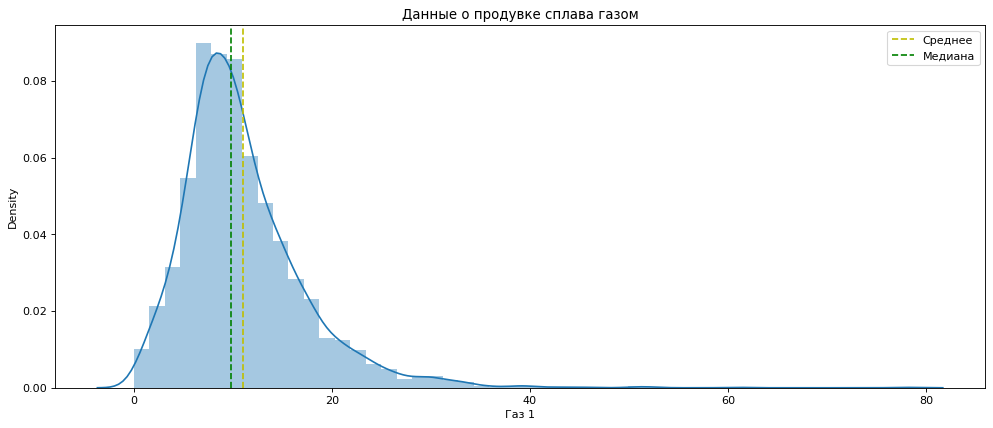

In [47]:
# посмотрим на распределение
plt.figure(figsize=(15, 6), dpi= 80)
sns.distplot(data_gas["Газ 1"], bins=50)
plt.axvline(data_gas["Газ 1"].mean(), ls='--', color='y', label='Среднее')
plt.axvline(data_gas["Газ 1"].median(), ls='--', color='g', label='Медиана')
plt.title("Данные о продувке сплава газом")
plt.legend()
plt.show()

### Вывод:  
Типы данных в этом датасете указаны правильно, дубликатов и пропусков нет, количество партий равно 3239.  
Распределение нормальное

### data_temp — результаты измерения температуры

In [48]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [49]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [50]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Тип данных в столбце **Время замера** указан неверно, есть пропуски в столбце **Температура**

In [51]:
data_temp.duplicated().sum()

0

In [52]:
data_temp["key"].nunique()

3216

In [53]:
#заменим тип данных
data_temp["Время замера"] = pd.to_datetime(data_temp["Время замера"])

In [54]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


In [55]:
#посмотрим на пропуски в столбце Температура
data_temp[data_temp["Температура"].isnull()]

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
...,...,...,...
15901,3240,2019-09-01 03:35:16,NaN
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


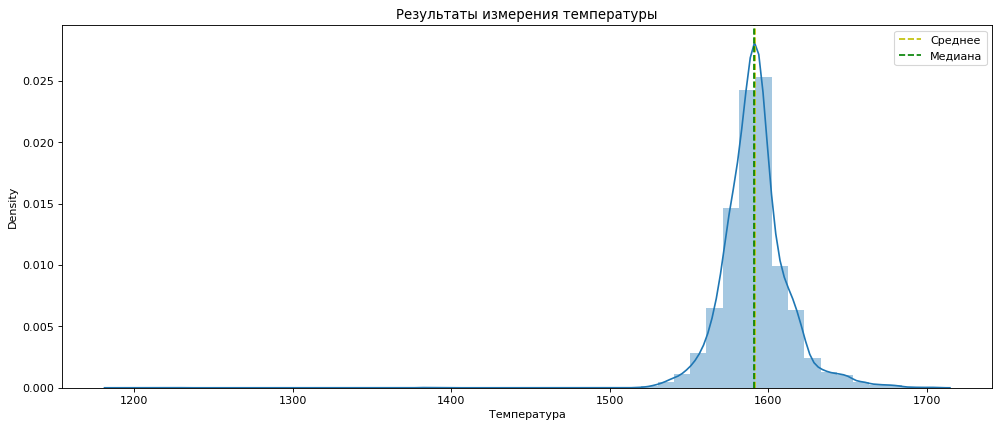

In [56]:
#построим график и посмотрим на распределение
plt.figure(figsize=(15, 6), dpi= 80)
sns.distplot(data_temp["Температура"], bins=50)
plt.axvline(data_temp["Температура"].mean(), ls='--', color='y', label='Среднее')
plt.axvline(data_temp["Температура"].median(), ls='--', color='g', label='Медиана')
plt.title("Результаты измерения температуры")
plt.legend()
plt.show()

### Вывод:  
Поменяли тип данных в столбце время замера на правильный. Дубликаты в ДФ отсутствуют, есть пропуски с 2500 партии в столбце Температура, так как это наш целевой признак при предобработке данных мы удалим эти данные. Распределение нормальное с наличием аномалий

### data_wire — данные о проволочных материалах (объём)

In [57]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [59]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [60]:
data_wire.duplicated().sum()

0

### Вывод:  
Типы данных указаны правильно, дубликаты отсутствуют, есть много пропусков в данных я думаю что они появились потому что разные виды проволочных материалов поступают в партии в разное время

### data_wire_time — данные о проволочных материалах (время).

In [61]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [63]:
data_wire_time.duplicated().sum()

0

In [64]:
data_wire_time.describe()

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


In [65]:
#заменим тип данных
data_wire_time["Wire 1"] = pd.to_datetime(data_wire_time["Wire 1"])
data_wire_time["Wire 2"] = pd.to_datetime(data_wire_time["Wire 2"])
data_wire_time["Wire 3"] = pd.to_datetime(data_wire_time["Wire 3"])
data_wire_time["Wire 4"] = pd.to_datetime(data_wire_time["Wire 4"])
data_wire_time["Wire 5"] = pd.to_datetime(data_wire_time["Wire 5"])
data_wire_time["Wire 6"] = pd.to_datetime(data_wire_time["Wire 6"])
data_wire_time["Wire 7"] = pd.to_datetime(data_wire_time["Wire 7"])
data_wire_time["Wire 8"] = pd.to_datetime(data_wire_time["Wire 8"])
data_wire_time["Wire 9"] = pd.to_datetime(data_wire_time["Wire 9"])

In [66]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


### Вывод:  
Мы заменили тип данных на правильный, есть много пропусков, дубликаты отсутствуют

## Общий вывод по разделу
Мы изучили данные в наших ДФ, в большинстве данных есть пропуски пока их не трокали, избавились от некоторых аномальных значений (отрицательной реактивной мощности), поменяди во всех ДФ тип данных на правильный, посмотрели на распределение данных, выяснили что активная мощности и реактивная мощность очень сильно зависят друг от друга поэтому мы ввели новый признак полная мощность. Так же в ходе анализа мы выяснили что по целевому признаку (температура) нет данных начиная с 2500 партии

Вопросы:  
1. Нужны ли ДФ времени.
2. Правильно ли я понял с целевым признаком что данные с 2500 партии надо отбросить?
3. Какие еще признаки можно ввести, есть ли необходимость посчитать время нагрева?
Пока вроде все, остальные вопросы по ходу работы.

# 2. Предобработка данных

In [67]:
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239
...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,0.640648
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,0.855559
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,0.874560
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,0.264489


In [68]:
#посчитаем общее время нагрева в секундах
data_arc["Общее время нагрева дугой"] = data_arc["Конец нагрева дугой"] - data_arc["Начало нагрева дугой"]
data_arc["Общее время нагрева дугой"] = data_arc["Общее время нагрева дугой"].dt.seconds
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Общее время нагрева дугой
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,148


In [69]:
#сгруппируем данные
data_arc_new = data_arc.groupby("key")[["Активная мощность", "Реактивная мощность", "Полная мощность", \
                         "Общее время нагрева дугой"]].sum().reset_index()
data_arc_new

,key,Активная мощность,Реактивная мощность,Полная мощность,Общее время нагрева дугой
0,1,4.878147,3.183241,5.826395,1098
1,2,3.052598,1.998112,3.649216,811
2,3,2.525882,1.599076,2.989534,655
3,4,3.209250,2.060298,3.814962,741
4,5,3.347173,2.252643,4.035758,869
...,...,...,...,...,...
3209,3237,3.932467,2.828459,4.844982,909
3210,3238,2.106529,1.681182,2.696542,546
3211,3239,4.666754,3.111617,5.611883,1216
3212,3240,2.984083,2.483267,3.891856,839


In [70]:
#посчитаем сколько раз выполнялся нагрев каждой партии
data_arc_key = data_arc.groupby("key")["Активная мощность"].count().reset_index()
data_arc_key.columns = ["key", "Количество раз нагрева"]
data_arc_key

,key,Количество раз нагрева
0,1,5
1,2,4
2,3,5
3,4,4
4,5,4
...,...,...
3209,3237,5
3210,3238,3
3211,3239,8
3212,3240,5


In [71]:
# объединим данные
data_arc = data_arc_new.merge(data_arc_key, how="left", on="key")
data_arc

,key,Активная мощность,Реактивная мощность,Полная мощность,Общее время нагрева дугой,Количество раз нагрева
0,1,4.878147,3.183241,5.826395,1098,5
1,2,3.052598,1.998112,3.649216,811,4
2,3,2.525882,1.599076,2.989534,655,5
3,4,3.209250,2.060298,3.814962,741,4
4,5,3.347173,2.252643,4.035758,869,4
...,...,...,...,...,...,...
3209,3237,3.932467,2.828459,4.844982,909,5
3210,3238,2.106529,1.681182,2.696542,546,3
3211,3239,4.666754,3.111617,5.611883,1216,8
3212,3240,2.984083,2.483267,3.891856,839,5


In [72]:
#выберем парти до 2500
data_arc = data_arc[data_arc["key"] < 2500]
data_arc

,key,Активная мощность,Реактивная мощность,Полная мощность,Общее время нагрева дугой,Количество раз нагрева
0,1,4.878147,3.183241,5.826395,1098,5
1,2,3.052598,1.998112,3.649216,811,4
2,3,2.525882,1.599076,2.989534,655,5
3,4,3.209250,2.060298,3.814962,741,4
4,5,3.347173,2.252643,4.035758,869,4
...,...,...,...,...,...,...
2470,2495,3.210690,2.360777,3.986869,723,4
2471,2496,4.203064,2.810185,5.057033,940,6
2472,2497,2.212379,1.851269,2.885017,569,3
2473,2498,3.408725,2.355428,4.143749,750,5


In [73]:
#посмотрим на корреляцию
data_arc.corr()

,key,Активная мощность,Реактивная мощность,Полная мощность,Общее время нагрева дугой,Количество раз нагрева
key,1.000000,-0.036510,0.000332,-0.022532,-0.034212,-0.034834
Активная мощность,-0.036510,1.000000,0.959727,0.993677,0.978192,0.754205
Реактивная мощность,0.000332,0.959727,1.000000,0.985069,0.966462,0.751501
Полная мощность,-0.022532,0.993677,0.985069,1.000000,0.982899,0.760402
Общее время нагрева дугой,-0.034212,0.978192,0.966462,0.982899,1.000000,0.795958
Количество раз нагрева,-0.034834,0.754205,0.751501,0.760402,0.795958,1.000000


Так как наши данные сильно коррелируют между собой отбросим их и оставим только те с которыми будем работать

In [74]:
data_arc = data_arc[["key", "Полная мощность", "Количество раз нагрева"]]
data_arc

,key,Полная мощность,Количество раз нагрева
0,1,5.826395,5
1,2,3.649216,4
2,3,2.989534,5
3,4,3.814962,4
4,5,4.035758,4
...,...,...,...
2470,2495,3.986869,4
2471,2496,5.057033,6
2472,2497,2.885017,3
2473,2498,4.143749,5


In [75]:
#выберем парти до 2500
data_bulk = data_bulk[data_bulk["key"] < 2500]
data_wire = data_wire[data_wire["key"] < 2500]

In [76]:
# заполним пропуски 0 в наших ДФ
data_bulk = data_bulk.fillna(0)
data_wire = data_wire.fillna(0)

In [77]:
data_temp = data_temp[data_temp["key"] < 2500]

In [78]:
# удалим пропуски из ДФ температуры
data_temp = data_temp.dropna(subset=['Температура']).reset_index(drop=True)
data_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
12262,2498,2019-08-06 02:19:26,1593.0
12263,2498,2019-08-06 02:25:31,1594.0
12264,2499,2019-08-06 02:40:25,1569.0
12265,2499,2019-08-06 02:54:24,1604.0


In [79]:
# удалим партии в которых только один замер температуры
data_temp_count = data_temp.groupby("key")["Температура"].count().reset_index()
data_temp_count

,key,Температура
0,1,5
1,2,6
2,3,5
3,4,3
4,5,2
...,...,...
2472,2495,3
2473,2496,4
2474,2497,2
2475,2498,5


In [80]:
one = data_temp_count[data_temp_count['Температура'] == 1]['key'].tolist()
data_temp = data_temp.query('key not in @one')
data_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
12262,2498,2019-08-06 02:19:26,1593.0
12263,2498,2019-08-06 02:25:31,1594.0
12264,2499,2019-08-06 02:40:25,1569.0
12265,2499,2019-08-06 02:54:24,1604.0


In [81]:
# сгруппируем данные по партиям где выберем первые и последние замеры
data_temp_new = data_temp.groupby("key").agg(["first", "last"]).reset_index()
data_temp_new.columns = data_temp_new.columns.droplevel()
data_temp_new.columns = ["key", "Время звмера 1", "Время замера 2", "Температура 1", "Температура 2"]
data_temp_new

,key,Время звмера 1,Время замера 2,Температура 1,Температура 2
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0
...,...,...,...,...,...
2470,2495,2019-08-06 00:35:45,2019-08-06 00:54:42,1570.0,1591.0
2471,2496,2019-08-06 01:02:54,2019-08-06 01:29:52,1554.0,1591.0
2472,2497,2019-08-06 01:41:53,2019-08-06 01:53:50,1571.0,1589.0
2473,2498,2019-08-06 02:03:49,2019-08-06 02:25:31,1591.0,1594.0


In [82]:
data_temp = data_temp_new[["key", "Температура 1", "Температура 2"]]
data_temp

,key,Температура 1,Температура 2
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2470,2495,1570.0,1591.0
2471,2496,1554.0,1591.0
2472,2497,1571.0,1589.0
2473,2498,1591.0,1594.0


In [83]:
#объеденим таблицу в одну
data = (data_temp.merge(data_arc, how="left", on="key")\
        .merge(data_bulk, how="left", on="key")\
        .merge(data_wire, how="left", on="key")\
        .merge(data_gas, how="left", on="key"))
        
data

,key,Температура 1,Температура 2,Полная мощность,Количество раз нагрева,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1
0,1,1571.0,1613.0,5.826395,5,0.0,0.0,0.0,43.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,2,1581.0,1602.0,3.649216,4,0.0,0.0,0.0,73.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,3,1596.0,1599.0,2.989534,5,0.0,0.0,0.0,34.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,4,1601.0,1625.0,3.814962,4,0.0,0.0,0.0,81.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,5,1576.0,1602.0,4.035758,4,0.0,0.0,0.0,78.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,2495,1570.0,1591.0,3.986869,4,0.0,0.0,21.0,0.0,0.0,...,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.125735
2471,2496,1554.0,1591.0,5.057033,6,0.0,0.0,0.0,63.0,0.0,...,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.412616
2472,2497,1571.0,1589.0,2.885017,3,0.0,0.0,0.0,85.0,0.0,...,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.271699
2473,2498,1591.0,1594.0,4.143749,5,0.0,0.0,90.0,0.0,0.0,...,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.953657


In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   key                     2475 non-null   int64  
 1   Температура 1           2475 non-null   float64
 2   Температура 2           2475 non-null   float64
 3   Полная мощность         2475 non-null   float64
 4   Количество раз нагрева  2475 non-null   int64  
 5   Bulk 1                  2407 non-null   float64
 6   Bulk 2                  2407 non-null   float64
 7   Bulk 3                  2407 non-null   float64
 8   Bulk 4                  2407 non-null   float64
 9   Bulk 5                  2407 non-null   float64
 10  Bulk 6                  2407 non-null   float64
 11  Bulk 7                  2407 non-null   float64
 12  Bulk 8                  2407 non-null   float64
 13  Bulk 9                  2407 non-null   float64
 14  Bulk 10                 2407 non-null   

In [85]:
#заполним пропуски 0
data = data.fillna(0)

In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   key                     2475 non-null   int64  
 1   Температура 1           2475 non-null   float64
 2   Температура 2           2475 non-null   float64
 3   Полная мощность         2475 non-null   float64
 4   Количество раз нагрева  2475 non-null   int64  
 5   Bulk 1                  2475 non-null   float64
 6   Bulk 2                  2475 non-null   float64
 7   Bulk 3                  2475 non-null   float64
 8   Bulk 4                  2475 non-null   float64
 9   Bulk 5                  2475 non-null   float64
 10  Bulk 6                  2475 non-null   float64
 11  Bulk 7                  2475 non-null   float64
 12  Bulk 8                  2475 non-null   float64
 13  Bulk 9                  2475 non-null   float64
 14  Bulk 10                 2475 non-null   

In [87]:
#переименуем столбцы
data = data.rename(columns={
    "Температура 1" : "Temp_1",
    "Температура 2" : "Temp_2",
    "Полная мощность" : "Full_power",
    "Количество раз нагрева" : "Iterations",
    "Газ 1" : "Gas"
})
data

,key,Temp_1,Temp_2,Full_power,Iterations,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Gas
0,1,1571.0,1613.0,5.826395,5,0.0,0.0,0.0,43.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,2,1581.0,1602.0,3.649216,4,0.0,0.0,0.0,73.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,3,1596.0,1599.0,2.989534,5,0.0,0.0,0.0,34.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,4,1601.0,1625.0,3.814962,4,0.0,0.0,0.0,81.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,5,1576.0,1602.0,4.035758,4,0.0,0.0,0.0,78.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,2495,1570.0,1591.0,3.986869,4,0.0,0.0,21.0,0.0,0.0,...,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.125735
2471,2496,1554.0,1591.0,5.057033,6,0.0,0.0,0.0,63.0,0.0,...,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.412616
2472,2497,1571.0,1589.0,2.885017,3,0.0,0.0,0.0,85.0,0.0,...,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.271699
2473,2498,1591.0,1594.0,4.143749,5,0.0,0.0,90.0,0.0,0.0,...,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.953657


In [88]:
#удалим столбец key
data = data.drop(["key"], axis=1)
data

,Temp_1,Temp_2,Full_power,Iterations,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Gas
0,1571.0,1613.0,5.826395,5,0.0,0.0,0.0,43.0,0.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,1581.0,1602.0,3.649216,4,0.0,0.0,0.0,73.0,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,1596.0,1599.0,2.989534,5,0.0,0.0,0.0,34.0,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,1601.0,1625.0,3.814962,4,0.0,0.0,0.0,81.0,0.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,1576.0,1602.0,4.035758,4,0.0,0.0,0.0,78.0,0.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,1570.0,1591.0,3.986869,4,0.0,0.0,21.0,0.0,0.0,0.0,...,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.125735
2471,1554.0,1591.0,5.057033,6,0.0,0.0,0.0,63.0,0.0,0.0,...,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.412616
2472,1571.0,1589.0,2.885017,3,0.0,0.0,0.0,85.0,0.0,0.0,...,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.271699
2473,1591.0,1594.0,4.143749,5,0.0,0.0,90.0,0.0,0.0,0.0,...,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.953657


## Вывод  
Мы провели предобработку данных, где заполнили пропуски данных 0, избавились от тех партий где есть пропуски по целевому признаку, удалили данные только с одной температурой и ввели понятие новых признаков, такие как - количество раз нагрева, начальная и конечная температура (наш целевой признак). Далее мы объеденили все наши данные в один ДФ где поменяли названия столбцов


# 3. Обучение модели

In [89]:
#разделим выборку
train, test = train_test_split(data, test_size = .30, random_state = 42)

In [90]:
#стандартизируем признаки
numeric = data.columns.tolist()
numeric = [i for i in numeric if i not in ('Temp_2')]
scaler = MinMaxScaler()
scaler.fit(train[numeric])

#масштабируем обучающую выборку
train[numeric] = scaler.transform(train[numeric])

#масштабируем тестовую выборку
test[numeric] = scaler.transform(test[numeric])

In [91]:
train.head()

,Temp_1,Temp_2,Full_power,Iterations,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Gas
1840,0.807377,1585.0,0.130278,0.133333,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.307736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.077957
2240,0.739754,1586.0,0.166019,0.333333,0.0,0.0,0.000000,0.562278,0.0,0.000000,...,0.462832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.188202
543,0.807377,1618.0,0.324607,0.333333,0.0,0.0,0.000000,0.451957,0.0,0.000000,...,0.461179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.269691
1721,0.790984,1600.0,0.164281,0.200000,0.0,0.0,0.000000,0.252669,0.0,0.000000,...,0.433125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.124366
2193,0.696721,1580.0,0.305321,0.333333,0.0,0.0,0.076404,0.000000,0.0,0.053678,...,0.233267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.135663


In [92]:
test.head()

,Temp_1,Temp_2,Full_power,Iterations,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Gas
873,0.770492,1591.0,0.214243,0.200000,0.237838,0.0,0.629213,0.0,0.0,0.0,...,0.305894,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.254902
2037,0.838115,1591.0,0.091565,0.133333,0.000000,0.0,0.276404,0.0,0.0,0.0,...,0.224143,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.107344
952,0.799180,1587.0,0.095651,0.200000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.257863,0.629906,0.0,0.0,0.0,0.0,0.0,0.0,0.311641,0.135709
1615,0.807377,1586.0,0.087121,0.133333,0.000000,0.0,0.134831,0.0,0.0,0.0,...,0.233211,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.047523
1712,0.909836,1597.0,0.053778,0.133333,0.000000,0.0,0.283146,0.0,0.0,0.0,...,0.311986,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.160983


In [93]:
print("Размер обучающей выборки:", train.shape)
print("Размер тестовой выобрки:", test.shape)

Размер обучающей выборки: (1732, 29)
Размер тестовой выобрки: (743, 29)


In [94]:
# Определим target и features для обучающей выборки
features_train = train.drop(["Temp_2"], axis = 1)
target_train = train["Temp_2"]

# Определим target и features для тестовой выборки
features_test = test.drop(["Temp_2"], axis = 1)
target_test = test["Temp_2"]

In [95]:
#определим модели
models = {
    "LGBMRegressor": lgb.LGBMRegressor(),
    "XGBRegressor": xgboost.XGBRegressor(),
    "LinearRegression": LinearRegression()
}

In [96]:
#укажем параметры
params = {
    "LinearRegression":{
            "fit_intercept" : [True, False],
            "normalize":[True,False]},  
    "LGBMRegressor": {
        "boosting_type": ["gbdt", "dart", "goss", "rf"],
        "objective": ["regression"],
        "learning_rate": [0.001, 0.01, 0.02, 0.03],
        "num_iterations":[500],
        "random_state": [42], 
        "max_depth": np.arange(2, 15),
        "metric": ["mae"]
        },   
    "XGBRegressor": {
        "min_child_weight": [10,20,30,40],
        "gamma": [5],
        "subsample": [1.0],
        "colsample_bytree": [1.0],
        "max_depth": [5,10,20],
        "eval_metric" :['mae'],
        "random_state" : [42]
        }
}

In [97]:
#подберем наилучшую модель
result = []
for name in models.keys():
            est = models[name]
            est_params = params[name]
            gscv = GridSearchCV(estimator=est, param_grid=est_params, cv=5)
            gscv.fit(features_train, target_train)
            predictions = gscv.predict(features_test)
            result.append({
            "model": name,
            "mae_score": mean_absolute_error(target_test, predictions),
            "best_params": gscv.best_params_
            })

In [98]:
#посмотрим на лучшую модель
model = xgboost.XGBRegressor(colsample_bytree=1.0, eval_metric="mae", gamma=5, max_depth=5, min_child_weight=40,\
                             random_state = 42, subsample=1.0)
model.fit(features_train,target_train)
predictions = model.predict(features_test)
print("MAE на тестовой выборке:", mean_absolute_error(target_test, predictions))

MAE на тестовой выборке: 6.285720927878954


## Вывод:  
Мы провели тесты на 3-х моделях, и лучшая из них это модель xgboost c результатом 6.28, а самая худшая LinearRegression с результатом 976

In [99]:
#посмотрим на важные признаки влияющие на нашу целевую переменную
df_feature_importance = pd.DataFrame(model.feature_importances_, index=features_test.columns, \
                                     columns=['feature importance']).sort_values('feature importance', ascending=False)
df_feature_importance

,feature importance
Bulk 5,0.242310
Wire 1,0.155132
Temp_1,0.122766
Full_power,0.086625
Bulk 1,0.073944
Wire 2,0.058052
Bulk 15,0.047287
Bulk 6,0.043089
Iterations,0.034435
Bulk 4,0.027362


<Figure size 1440x432 with 0 Axes>

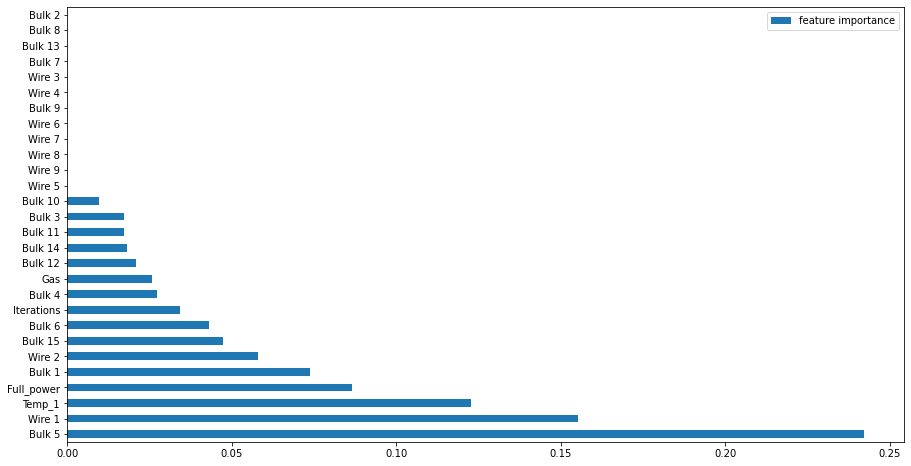

In [104]:
plt.figure(figsize=(20, 6))
df_feature_importance.plot(kind='barh', figsize=(15, 8));

# Общий вывод:  
Мы провели исследовательский анализ данных, провели предобработку данных, избавились от пропусков и выбросов, сменили типы данных на правильные, так же мы выяснили что целевой признак у нас есть только по 2500 партию.
При проведении обучения моделей мы использовали 3 модели: **LGBMRegressor, XGBRegressor, LinearRegression**, наилучший результат показала модель **XGBRegressor = 6.28**.  
Мы видим что самыми важными признакками влияющими на нашу переменную являются **Bulk 5, Wire 1, Temp 1, Full_power**

# Отчет

* Нам удалось выполнить все пункты Плана.
* Тяжелее всего при выполнее Плана было сформировать новые признаки из наших данных, разобраться в сути производственного процесса. Преодолевая их я читал информацию в интерене смотрел видео и эксперементировал с разными признаками и в итоге остановился на тех что использовал в модели.
* На мой взляг ключивыми шагами можно выделить поиск признаков, корреляция между ними и обработка целевого признака.
* Наилучший результат показала модель XGBRegressor = 6.28.